In [1]:
# Import necessary libraries
import librosa
import soundfile
import os, glob
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [14]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    if chroma:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    
    return result

In [15]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Emotions to observe
observed_emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [16]:
# Load data function
def load_data(test_size=0.2):
    x, y = [], []
    files = sorted(glob.glob('RAVDESS_data/**/*.wav', recursive=True))

    # Print number of files found
    print(f"Number of audio files found: {len(files)}")

    for file in files:
        file_name = os.path.basename(file)
        emotion = emotions.get(file_name.split("-")[2])
        
        if emotion not in observed_emotions:
            continue
        
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    
    return train_test_split(np.array(x), y, test_size=test_size, train_size=0.75, random_state=9)

In [17]:

# Call the function
x_train, x_test, y_train, y_test = load_data(test_size=0.25)


Number of audio files found: 2880


In [18]:
# Print the shape of the training and testing datasets
print(f"Training data size: {x_train.shape[0]}, Testing data size: {x_test.shape[0]}")
print(f"Features extracted: {x_train.shape[1]}")

Training data size: 2160, Testing data size: 720
Features extracted: 180


In [19]:
# === Compare with other classifiers ===
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Dictionary of models to compare
models = {
    "MLP": MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08,
                         hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Linear)": SVC(kernel='linear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Dictionary to store predictions for each model
predictions = {}

# Train and evaluate models, print metrics
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    predictions[name] = y_pred  # Store prediction
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


=== MLP ===
Accuracy: 75.14%
Classification Report:
              precision    recall  f1-score   support

       angry       0.87      0.85      0.86        98
        calm       0.70      0.84      0.76       106
     disgust       0.65      0.86      0.74        94
     fearful       0.82      0.92      0.87        86
       happy       0.74      0.78      0.76        86
     neutral       0.48      0.66      0.56        44
         sad       0.86      0.54      0.67       103
   surprised       0.92      0.55      0.69       103

    accuracy                           0.75       720
   macro avg       0.76      0.75      0.74       720
weighted avg       0.78      0.75      0.75       720


=== Random Forest ===
Accuracy: 90.28%
Classification Report:
              precision    recall  f1-score   support

       angry       0.94      0.92      0.93        98
        calm       0.89      0.96      0.93       106
     disgust       0.92      0.94      0.93        94
     fearful    

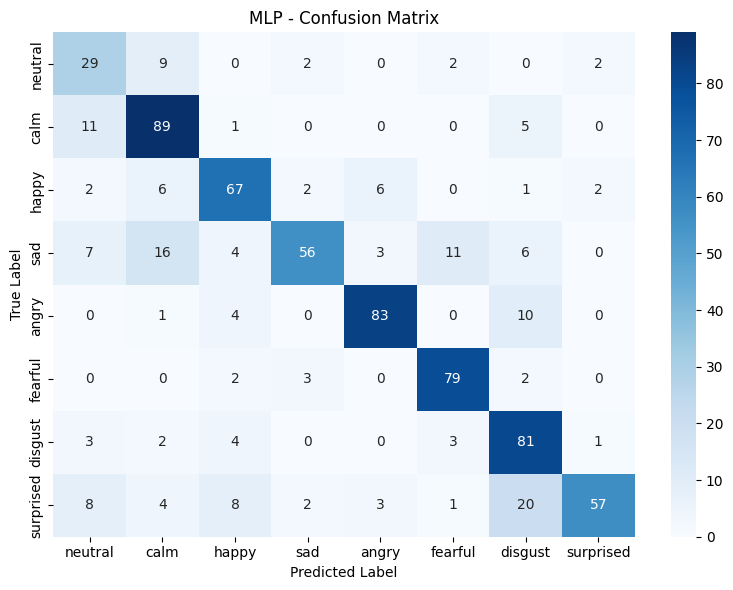

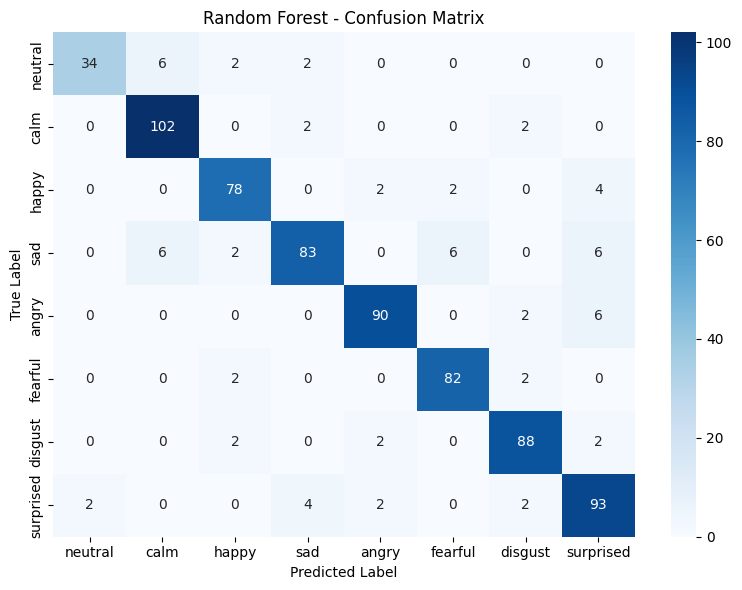

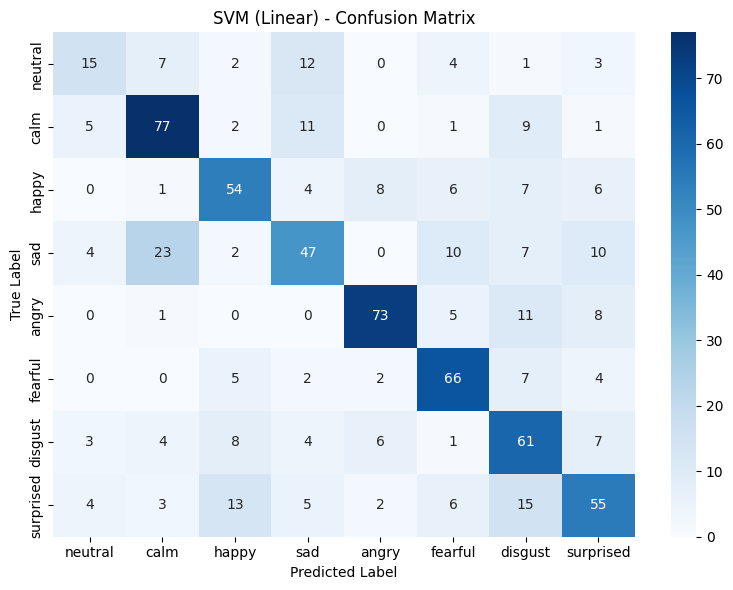

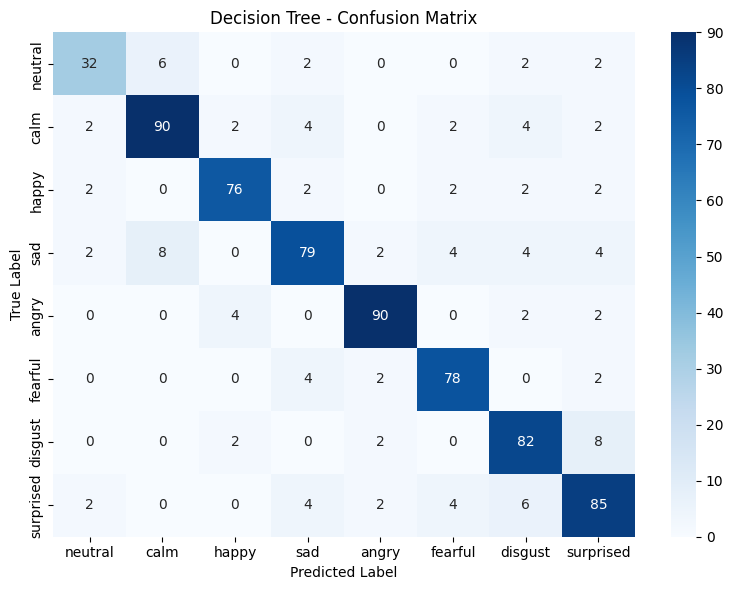

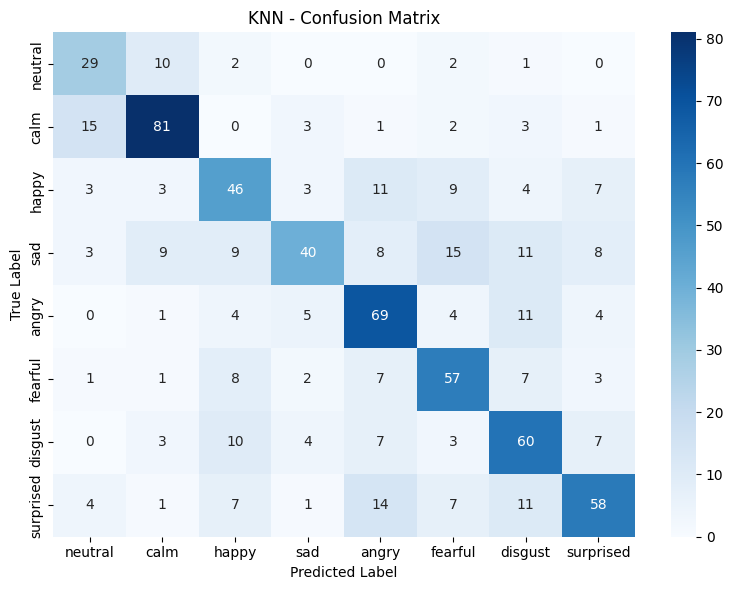

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrices
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred, labels=observed_emotions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=observed_emotions, yticklabels=observed_emotions)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [23]:
print("\nModel Accuracies:")
for name in predictions:
    acc = accuracy_score(y_test, predictions[name]) * 100
    print(f"{name}: {acc:.2f}%")



Model Accuracies:
MLP: 75.14%
Random Forest: 90.28%
SVM (Linear): 62.22%
Decision Tree: 85.00%
KNN: 61.11%


In [25]:
# Save all models after training and evaluation
import joblib 

for name, model in models.items():
    joblib.dump(model, f"{name}_model.joblib")
    print(f"{name} model saved as {name}_model.joblib")

MLP model saved as MLP_model.joblib
Random Forest model saved as Random Forest_model.joblib
SVM (Linear) model saved as SVM (Linear)_model.joblib
Decision Tree model saved as Decision Tree_model.joblib
KNN model saved as KNN_model.joblib
